# LIME on different pictures

In this notebook we will look on LIME based on a Resnet Model trained with imagenet.
LIME is based on the paper (Ribeiro et al, 2016). Also the code is based on (2).

## How does LIME work?

The goal of LIME is understanding the model $ m $.
LIME uses a local example and uses similar examples $ v_i $ to predict an result $ p_i = m(v_i) $. 
These similar example also have a local representation $v'_i $ (in our case $ v'_i \in \{ 0, 1\}^d $)
We train a smaller model $m' $ to predict $p_i$ with $v'_i$ as an input.




## How do we use LIME here?

We take an image as a local example. We divide it under superpixel (via quickshift or grids). Now we give every superpixel an indice with a value. If the value has an 1, we just use the superpixel as an input. In case of 0 , we black out the area. Together of all values we have the local representation and also the similar examples of our local example. 

Now we use this modified image (with the black out superpixel) as an input for the original model and get the predication for one class.
If we have sufficient examples (usually the number of superpixels), we train a linear model with the representation as an input and the prediction of the class as an output. 

By looking at highest coefficients of the linear model we can see which superpixel is the most important one. 



## General preparations

Here we see the imports and the loading of the model. ResNet50 is a good starting point, mentioned very often in the torchvision docs


In [1]:
import torch
import torchvision
import json
import matplotlib.pyplot as plt

import skimage.io 
import skimage.segmentation
import numpy as np
import copy
from sklearn.linear_model import LinearRegression
import math

In [ ]:
model = torch.hub.load("pytorch/vision:v0.13.0", "resnet50", weights="IMAGENET1K_V2", skip_validation=True)
model = model.cuda()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0


In [ ]:
torch.save(model, open('resnet50.model', "wb+"))

In [ ]:
model = torch.load(open('resnet50.model', 'rb'))

In [ ]:
imagenet_class_to_text = json.load(open('imagenet_classes.json', 'r'))

## Load image, Labrador image

In [ ]:
Here we will use a labrador picture with the quickshift algorithm for segmentation.

example_image = torchvision.io.read_image('labardor1.jpg')
example_image = example_image.float() / 255
example_image = torch.unsqueeze(example_image, dim=0)

pred = torch.nn.functional.softmax(model(example_image), dim=1)

pred = model(example_image)

list_topks_class = torch.topk(pred, k=10)[1].tolist()[0]
list_topks_probs = torch.topk(pred, k=10)[0].tolist()[0]

In [ ]:
[
    (prob, imagenet_class_to_text[str(i_class)], i_class)
    for i_class, prob in zip(list_topks_class, list_topks_probs)
]

[(0.0016128947027027607, ['n02099712', 'Labrador_retriever'], 208),
 (0.0015165135264396667, ['n02077923', 'sea_lion'], 150),
 (0.0014997090911492705, ['n02088364', 'beagle'], 162),
 (0.0014973353827372193, ['n04557648', 'water_bottle'], 898),
 (0.0014654111582785845, ['n04409515', 'tennis_ball'], 852),
 (0.0014613106613978744, ['n03876231', 'paintbrush'], 696),
 (0.0014339541085064411, ['n02090379', 'redbone'], 168),
 (0.0014249102678149939, ['n04049303', 'rain_barrel'], 756),
 (0.0014147614128887653, ['n02134084', 'ice_bear'], 296),
 (0.0013748651836067438, ['n02104029', 'kuvasz'], 222)]

Now we see the highest prediction is a labrador.

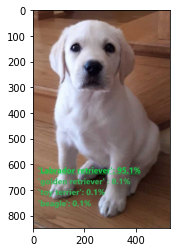

In [ ]:
plt.imshow(example_image[0].permute(1, 2, 0) ) #https://stackoverflow.com/questions/53623472/how-do-i-display-a-single-image-in-pytorch
plt.show()

In [ ]:
superpixels = skimage.segmentation.quickshift(example_image[0].permute(1, 2, 0).double(), kernel_size=16,max_dist=200, ratio=0.2)

In [ ]:
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

19

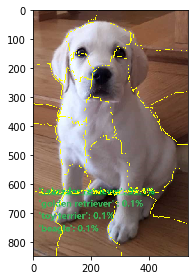

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(example_image[0].permute(1, 2, 0).detach().numpy(), superpixels))

In [ ]:
num_perturb = num_superpixels #lineare regressino works like that #150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] 

array([1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1])

In [ ]:
len(perturbations)

87

In [ ]:


def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image



In [ ]:
perturb = perturb_image(example_image[0].permute(1, 2, 0),perturbations[0],superpixels)

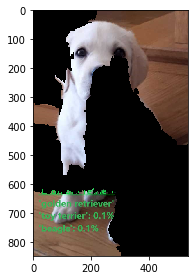

In [ ]:


skimage.io.imshow(perturb.detach().numpy())

In [ ]:
predictions = list()
model.eval()

model = model.cuda()

for i in range(0, perturbations.shape[0], 5):
    print(i)
    current_images = list()
    for j in range(0, 5):
        pointer = min(i + j, len(perturbations))
        if i + j >= len(perturbations):
            break
        ski_perturbed_img = perturb_image(
            example_image[0].permute(1, 2, 0),
            perturbations[pointer],
            superpixels)
        perturbed_img = torch.permute(ski_perturbed_img, [2, 0, 1])
        current_images.append(perturbed_img)
    batch_x = torch.stack(current_images)
    pred = model(batch_x.float().cuda())
    predictions.append(pred.detach())

0
5
10
15


In [ ]:
pred = torch.cat(predictions)

In [ ]:
pred_softmax = torch.nn.functional.softmax(pred, dim=1).detach().cpu()

In [ ]:
test_class = 208
y_pred = [
    pred_softmax[element_i][test_class].detach().numpy()
    for element_i in range(pred_softmax.shape[0])
]

In [ ]:
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=y_pred)


LinearRegression()

In [ ]:
coeff = simpler_model.coef_
coeff

array([-3.10990666e-04,  1.69565055e-03,  6.24426303e-04,  7.80467050e-04,
        1.37761703e-03,  1.01442689e-03,  1.05080512e-03,  2.46794914e-04,
        2.76197101e-04, -2.91665189e-04,  5.84892487e-04,  1.26825939e-04,
        6.68536795e-05,  1.11754969e-03, -3.70844386e-04,  9.42407724e-04,
        6.99222760e-04,  8.69517271e-04, -3.60970096e-04])

In [ ]:


num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features



array([ 6, 13,  4,  1])

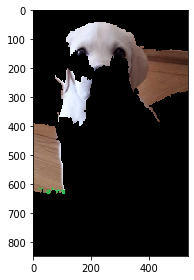

In [ ]:


mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
drawing = perturb_image(example_image[0].permute(1, 2, 0),mask,superpixels) 
skimage.io.imshow(drawing.detach().numpy())



It is clear now, that the prediction is made on based charactistics on the dog's head as well the wooden floor. Clearly there is potencial for better results.

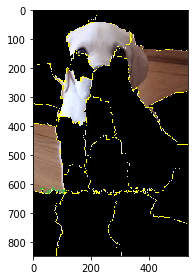

In [ ]:
drawing_wo_borders = example_image[0].permute(1, 2, 0).detach().numpy()
drawing_wi_borders = skimage.segmentation.mark_boundaries( perturb_image(example_image[0].permute(1, 2, 0),mask,superpixels).detach().numpy(), superpixels)


skimage.io.imshow(drawing_wi_borders)

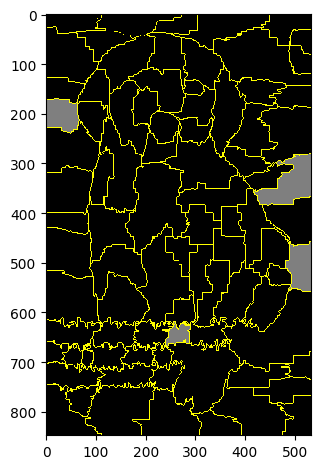

In [ ]:
white_pic = perturb_image(np.ones(example_image[0].permute(1, 2, 0).shape) * 0.5,mask,superpixels) 
white_pic_wi_borders = skimage.segmentation.mark_boundaries( white_pic , superpixels)

skimage.io.imshow(white_pic_wi_borders) 

## Load image (cat poster)

Now we will take a larger picture. The problem with quickshift is, that is not very efficient. Instead I coded my own algorithm getting a grid. Grids are very arbitary but easily created in constraint enviroments

In [ ]:




def create_grid_segmentation(
    img,
    grid_n_x_axes = 10,
    grid_n_y_axes = 10
    ):
    size_y = img.shape[1]
    size_x = img.shape[0]

    step_y = math.floor(size_y / grid_n_y_axes)
    step_x = math.floor(size_x / grid_n_x_axes)

    class_area = 1
    result_pic = np.zeros((size_x, size_y), dtype=int)

    whiteboard = np.zeros(example_image.shape)
    for x_lower_border in range(0, size_x, step_x, ):
        for y_lower_border in range(0, size_y, step_y):
            x_higher_border = min(x_lower_border + step_x, size_x)
            y_higher_border = min(y_lower_border + step_y, size_y)

            if x_lower_border == x_higher_border or y_lower_border == y_higher_border:
                continue

            np_area = np.ones((x_higher_border - x_lower_border, y_higher_border - y_lower_border))  * class_area
            result_pic[x_lower_border:x_higher_border, y_lower_border:y_higher_border] = \
                np_area
            class_area += 1
    return result_pic



In [ ]:
example_image = torchvision.io.read_image('Cat_poster_1.jpg')
example_image = example_image.float() / 255
example_image = torch.unsqueeze(example_image, dim=0)

In [ ]:
pred = torch.nn.functional.softmax(model(example_image.cuda()), dim=1)

In [ ]:
list_topks_class = torch.topk(pred, k=10)[1].tolist()[0]
list_topks_probs = torch.topk(pred, k=10)[0].tolist()[0]

In [ ]:
[
    (prob, imagenet_class_to_text[str(i_class)], i_class)
    for i_class, prob in zip(list_topks_class, list_topks_probs)
]

[(0.00179850566200912, ['n02124075', 'Egyptian_cat'], 285),
 (0.0016059461049735546, ['n02123597', 'Siamese_cat'], 284),
 (0.0015742555260658264, ['n04409515', 'tennis_ball'], 852),
 (0.0015224986709654331, ['n02123045', 'tabby'], 281),
 (0.0015168727841228247, ['n02909870', 'bucket'], 463),
 (0.0015026915352791548, ['n02123159', 'tiger_cat'], 282),
 (0.0014915618812665343, ['n04404412', 'television'], 851),
 (0.0014814415480941534, ['n03887697', 'paper_towel'], 700),
 (0.0014451046008616686, ['n02085620', 'Chihuahua'], 151),
 (0.0014328917022794485, ['n02939185', 'caldron'], 469)]

Now we see the algorithm predicts two races of cats. Lets see why

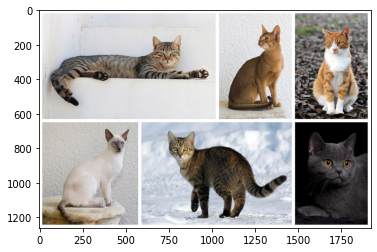

In [ ]:
plt.imshow(example_image[0].permute(1, 2, 0) ) 
plt.show()

In [ ]:
superpixels = create_grid_segmentation(example_image[0].permute(1, 2, 0), grid_n_x_axes=9, grid_n_y_axes=9)

In [ ]:
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

100

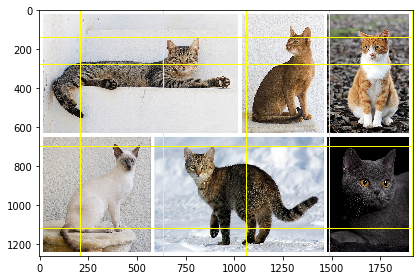

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(example_image[0].permute(1, 2, 0).detach().numpy(), superpixels))

(The algorithm of skimage has a bug, as the middle areas dont have an equal area. We can see it on the perturbation picture)

In [ ]:
num_perturb = num_superpixels #lineare regressino works like that #150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] 

array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0])

In [ ]:


def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image



In [ ]:
perturb = perturb_image(example_image[0].permute(1, 2, 0),perturbations[0],superpixels)

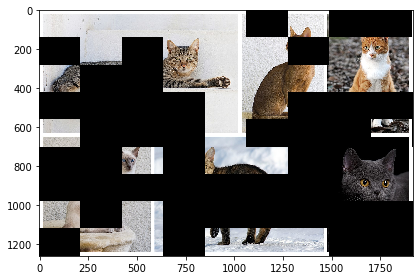

In [ ]:


skimage.io.imshow(perturb.detach().numpy())

In [ ]:
predictions = list()
model.eval()

for i in range(0, perturbations.shape[0]):
    print(i)

    ski_perturbed_img = perturb_image(
        example_image[0].permute(1, 2, 0),
        perturbations[i],
        superpixels)
    print(ski_perturbed_img.shape)
    perturbed_img = torch.permute(ski_perturbed_img, [2, 0, 1])
    perturbed_img = torch.unsqueeze(perturbed_img, dim=0)

    pred = model(perturbed_img.float().cuda())
    predictions.append(pred.detach().cpu())

0
torch.Size([1261, 1920, 3])
1
torch.Size([1261, 1920, 3])
2
torch.Size([1261, 1920, 3])
3
torch.Size([1261, 1920, 3])
4
torch.Size([1261, 1920, 3])
5
torch.Size([1261, 1920, 3])
6
torch.Size([1261, 1920, 3])
7
torch.Size([1261, 1920, 3])
8
torch.Size([1261, 1920, 3])
9
torch.Size([1261, 1920, 3])
10
torch.Size([1261, 1920, 3])
11
torch.Size([1261, 1920, 3])
12
torch.Size([1261, 1920, 3])
13
torch.Size([1261, 1920, 3])
14
torch.Size([1261, 1920, 3])
15
torch.Size([1261, 1920, 3])
16
torch.Size([1261, 1920, 3])
17
torch.Size([1261, 1920, 3])
18
torch.Size([1261, 1920, 3])
19
torch.Size([1261, 1920, 3])
20
torch.Size([1261, 1920, 3])
21
torch.Size([1261, 1920, 3])
22
torch.Size([1261, 1920, 3])
23
torch.Size([1261, 1920, 3])
24
torch.Size([1261, 1920, 3])
25
torch.Size([1261, 1920, 3])
26
torch.Size([1261, 1920, 3])
27
torch.Size([1261, 1920, 3])
28
torch.Size([1261, 1920, 3])
29
torch.Size([1261, 1920, 3])
30
torch.Size([1261, 1920, 3])
31
torch.Size([1261, 1920, 3])
32
torch.Size([126

In [ ]:
pred = torch.cat(predictions)

In [ ]:
pred_softmax = torch.nn.functional.softmax(pred, dim=1)

Now we will use lime twice to test two classes.

In [ ]:
test_class = 285
y_pred = [
    pred_softmax[element_i][test_class].detach().numpy()
    for element_i in range(pred_softmax.shape[0])
]

In [ ]:
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=y_pred)


LinearRegression()

In [ ]:
coeff = simpler_model.coef_
coeff

array([-1.44965477e-04, -6.76593584e-04,  3.05640853e-04,  3.29275729e-04,
       -3.66619821e-04,  6.40904631e-05,  7.62395459e-04,  6.93783326e-04,
        3.58816888e-04, -1.00705378e-04, -7.15653788e-05,  8.17537868e-04,
       -2.89917007e-04,  9.58399544e-05,  4.78096491e-04,  4.09890021e-04,
       -9.28744576e-05, -1.86459708e-04,  3.99745248e-04,  9.87845225e-04,
       -1.33178720e-03,  5.83778380e-04,  8.03979627e-04,  6.92006079e-04,
        1.37323261e-04,  7.55958385e-05, -5.03712257e-04, -3.43749734e-06,
       -6.23258230e-05,  2.17875912e-04, -2.71402070e-04, -1.01801596e-04,
        3.06439243e-04, -1.56427003e-04, -1.66344150e-04,  8.81035375e-04,
       -3.28356312e-05,  1.59623973e-04,  4.78043680e-04, -5.78287972e-05,
        1.95259721e-05, -1.03514253e-03, -1.87950685e-04,  8.38022001e-04,
       -2.14377770e-04, -9.61038611e-04, -5.63817949e-05,  9.39586734e-04,
       -8.38837530e-04,  3.94077321e-05, -1.99548441e-05,  8.54812685e-06,
       -1.13411490e-04,  

In [ ]:


num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features



array([47, 64, 19, 53])

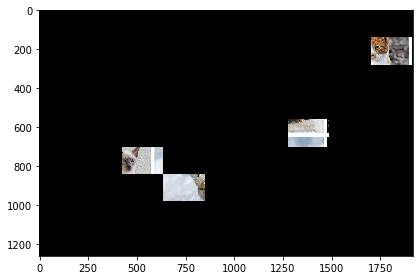

In [ ]:


mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
drawing = perturb_image(example_image[0].permute(1, 2, 0),mask,superpixels) 
skimage.io.imshow(drawing.detach().numpy())



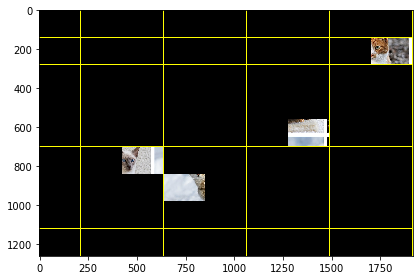

In [ ]:
drawing_wo_borders = example_image[0].permute(1, 2, 0).detach().numpy()
drawing_wi_borders = skimage.segmentation.mark_boundaries( perturb_image(example_image[0].permute(1, 2, 0),mask,superpixels).detach().numpy(), superpixels)


skimage.io.imshow(drawing_wi_borders)

In [ ]:
test_class = 286
y_pred = [
    pred_softmax[element_i][test_class].detach().numpy()
    for element_i in range(pred_softmax.shape[0])
]

In [ ]:
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=y_pred)


LinearRegression()

In [ ]:
coeff = simpler_model.coef_
coeff

array([-6.15065568e-05, -1.00164317e-04,  2.37481266e-04,  1.62506337e-04,
       -2.03591487e-04,  1.78727055e-04,  2.50990246e-05,  3.76083725e-04,
        2.36860793e-04,  9.32237144e-05,  5.64356642e-05,  5.21174301e-04,
       -1.82931236e-04, -1.83819985e-05, -1.97597167e-04,  1.64898340e-04,
       -2.69081937e-05, -3.10949821e-04,  9.92880019e-05,  5.20021505e-04,
       -4.95607097e-04,  4.38150910e-04,  3.66768320e-04,  4.23698549e-04,
       -2.42438542e-05,  1.23093917e-04, -1.61629749e-04, -1.79786526e-04,
        1.00143812e-04,  1.69664540e-04, -4.41462945e-04, -3.17628884e-04,
        3.81671672e-04, -2.34211505e-04, -4.00058471e-05,  3.80019531e-04,
        2.25179306e-04,  1.19315314e-04,  2.50662965e-04, -2.38663301e-05,
       -9.70796938e-06, -4.16188521e-04, -3.80533135e-05,  2.54872067e-04,
       -1.64269980e-04, -2.50984068e-04,  5.32916413e-05,  5.60647060e-04,
       -3.19208609e-04,  3.34538044e-05,  3.69344608e-05, -1.09631203e-04,
        1.21860565e-04,  

In [ ]:


num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features



array([19, 11, 47, 53])

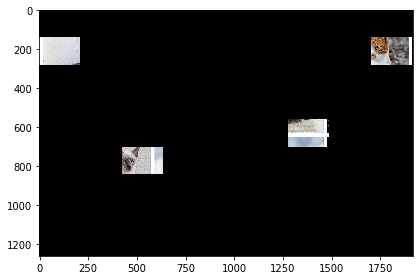

In [ ]:


mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
drawing = perturb_image(example_image[0].permute(1, 2, 0),mask,superpixels) 
skimage.io.imshow(drawing.detach().numpy())



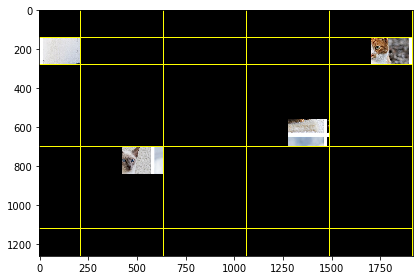

In [ ]:
drawing_wo_borders = example_image[0].permute(1, 2, 0).detach().numpy()
drawing_wi_borders = skimage.segmentation.mark_boundaries( perturb_image(example_image[0].permute(1, 2, 0),mask,superpixels).detach().numpy(), superpixels)


skimage.io.imshow(drawing_wi_borders)

We see thanks to LIME that the model uses the same parts of the pictures for the prediction. We can assume the algorithm cant see the difference between both classes very well.

## Sources

(1) Ribeiro, Marco Tulio et al. “"Why Should I Trust You?": Explaining the Predictions of Any Classifier.” Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (2016): n. pag.
(2) Artega, Christian: "Interpretable Machine Learning with LIME for Image Classification". https://nbviewer.org/url/arteagac.github.io/blog/lime_image.ipynb